# Uterine fibroids follow-up treatment meta-analysis

Our goal is to estimate the probabilities of requiring one of a suite of candidate follow-up treatments following randomization to a given initial treatment for uterine fibroids. Specifically, we are interested in estimating:

$$Pr(I_2|I_1 =i,T=t)$$

where $I_1$ is an initial intervention, which take specific values $i = 1, 2, \ldots , K$ for each of $K$ candidate intervention types, $I_2$ is the followup intervention that also may take any of the same values of $i$, and $T$ is followup time in months, which will generally be either 6 or 12 months.

Our current set of candidate interventions include:

- Myomectomy
- Hysterectomy
- Ablation
- UAE
- Magnetic resonance imaging-guided high-intensity focused ultrasound (MRIgFUS) 
- Ablation +/- hysteroscopic myomectomy
- No intervention

Rather than model each conditional probability independently, we will instead model the outcomes for a treatment arm as a multinomial random variable. That is,

$$\{X_{I_2} \} ∼ \text{Multinomial}(N_{I_1}=i, \{\pi_i\})$$

where $\{X_{I_2}\}$ is the vector of outcomes corresponding to each of the possible followup interventions listed above, $N_{I_1}=i$ is the number of women randomized to the initial intervention i, and $\{\pi_i\}$ is a vector of conditional transition probabilities corresponding to $Pr(I_2|I_1 = i, T = t)$, as specified above. The multinomial distribution is a multivariate generalization of the categorical distribution, which is what the above simplifies to when modeling the outcome for a single patient. The multivariate formulation allows us to model study-arm-specific outcomes, incorporating covariates that are specific to that arm or study.
       
The quantities of interest are the vectors of transition probabilities $\{\pi_i\}$ corresponding to each of the initial candidate interventions. A naive approach to modeling these is to assign a vague Dirichlet prior distribution to each set, and perform Bayesian inference using the multinomial likelihood, with which the Dirichlet is conjugate, to yield posterior estimates for each probability. However, there may be additional information with which to model these probabilities, which may include:

- followup time for each study
- arm-specific demographic covariates (e.g. race, mean age) 
- study-specific random effects

hence, a given transition probability $\pi_{ijk}$ – the probability of transitioning from initial intervention $i$ to followup intervention $j$ in study $k$ – may be modeled as:

$$\text{logit}(\pi_{ijk})= \theta_{ij} + X_k \beta_{ij} + \epsilon_k$$

where $\theta_{ij}$ is a baseline transition probability (on the logit scale), $X_k$ a matrix of study(-arm)-specific covariates, $\beta_{ij}$ the corresponding coefficients, and $\epsilon_k$ a mean-zero random effect for study k. We will initially consider (1) follow-up time and (2) mean/median age as covariates.
 
An attractive benefit to using Bayesian inference to estimate this model is that it is easy to generate predictions from the model, via the posterior predictive distribution. For example, we could estimate the distribution of the expected proportion of women requiring a particular followup intervention; this estimate would factor in both the residual uncertainty in the transition probability estimates, as well as the sampling uncertainty of the intervention.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import pdb
sns.set()

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Data Preparation

Import data from worksheets in Excel spreadsheet.

In [2]:
data_file = 'UF Subsequent Interventions Data_Master_updated.xlsx'

In [3]:
missing = ['NA', 'NR', 'ND', '?', 'null']

misc_data = pd.read_excel('data/' + data_file, sheetname='MISC (SP)', na_values=missing)
misc_data = misc_data[~misc_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = misc_data.shape
print('Occlusion rows={0}, columns={1}, missing={2}'.format(rows, cols,
                                                        misc_data.isnull().sum().sum()))

med_vs_iac_data = pd.read_excel('data/' + data_file, sheetname='Med vs IAC JW', na_values=missing)
med_vs_iac_data = med_vs_iac_data[~med_vs_iac_data['trial_arm'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_iac_data.shape
print('Med vs IAC rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_iac_data.isnull().sum().sum()))

med_vs_med_data = pd.read_excel('data/' + data_file, sheetname='Med vs Med DVE', na_values=missing)
med_vs_med_data = med_vs_med_data[~med_vs_med_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = med_vs_med_data.shape
print('Med vs Med rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            med_vs_med_data.isnull().sum().sum()))

uae_data = pd.read_excel('data/' + data_file, sheetname='UAE SK')
uae_data = uae_data[~uae_data['baseline_n'].isnull()].drop('notes', axis=1)
rows, cols = uae_data.shape
print('UAE rows={0}, columns={1}, missing={2}'.format(rows, cols, 
                                                            uae_data.isnull().sum().sum()))

datasets = [misc_data, med_vs_iac_data, med_vs_med_data, uae_data]

Occlusion rows=31, columns=13, missing=6
Med vs IAC rows=49, columns=13, missing=46
Med vs Med rows=67, columns=13, missing=13
UAE rows=32, columns=13, missing=0


In [4]:
unique_inerventions = set(np.concatenate([d.intervention.values for d in datasets]))

Use the following lookup table to create "intervention category" field in each dataset.

In [5]:
# %load intervention_lookup.py
intervention_lookup = {'Ablation': 'ablation',
 'Ablation+/- hysteroscopic myomectomy': 'ablation',
 'Asoprisnil 10 mg': 'med_manage',
 'Asoprisnil 25 mg': 'med_manage',
 'Asoprisnil 5 mg': 'med_manage',
 'Ulipristal (CD20)': 'med_manage',
 'Ulipristal (CDB10)': 'med_manage',
 'Hysterectomy': 'hysterectomy',
 'LBCUV': 'uae',
 'LP + GnRH agonist plus raloxifene': 'med_manage',
 'LP + placebo': 'med_manage',
 'LPA+ MPA / LPA+placebo': 'med_manage',
 'LPA+ placebo / LPA+MPA': 'med_manage',
 'LUNA plus LBCUV': 'ablation',
 'Myomectomy': 'myomectomy',
 'No treatment': 'control',
 'No treatment (control)': 'control',
 'Placebo': 'control',
 'Raloxifene, 180mg/day': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (3 months) then tibolone 2.5 mg daily (3 months)': 'med_manage',
 'SC implant of 3.6 goserelin + placebo (6 months)': 'med_manage',
 'SC implant of 3.6 goserelin + tibolone 2.5 mg daily (6 months)': 'med_manage',
 'Surgery': 'DROP',
 'Tibolone': 'med_manage',
 'UAE': 'uae',
 'UAE only': 'uae',
 'UAE plus goserelin acetate depot': 'uae',
 'buserelin + goserelin': 'med_manage',
 'buserelin, intranasal': 'med_manage',
 'cabergoline': 'med_manage',
 'diphereline': 'med_manage',
 'gestrinone, 2.5mg': 'med_manage',
 'gestrinone, 2.5mg oral + gestrinone, 5mg oral + gestrinone, 5mg vaginal': 'med_manage',
 'gestrinone, 5mg': 'med_manage',
 'gestrinone, 5mg vaginal': 'med_manage',
 'goserelin, subcutaneous': 'med_manage',
 'healthy controls': 'control',
 'hormone replacement therapy, transdermal': 'DROP',
 'hysterectomy or myomectomy': 'DROP',
 'letrozole, 2.5mg': 'med_manage',
 'leuprolide': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + Placebo': 'med_manage',
 'leuprolide acetate depot (11.25 mg q 3 months) + tibolone 2.5 mg/d orally': 'med_manage',
 'leuprolide acetate depot (3.75 mg/28 d) + placebo (B)': 'med_manage',
 'leuprolide plus (tibolone 2.5 mg daily) (A)': 'med_manage',
 'leuprolide plus MPA': 'med_manage',
 'leuprolide plus estrogen-progestin': 'med_manage',
 'leuprolide plus placebo': 'med_manage',
 'leuprolide plus progestin': 'med_manage',
 'leuprolide plus raloxifene 60 mg daily': 'med_manage',
 'leuprolide, 1.88mg': 'med_manage',
 'leuprolide, 3.75mg': 'med_manage',
 'mifepristone, 10mg': 'med_manage',
 'mifepristone, 10mg + mifepristone, 5mg': 'med_manage',
 'mifepristone, 2.5mg': 'med_manage',
 'mifepristone, 5mg': 'med_manage',
 'placebo': 'control',
 'raloxifene 180 mg daily': 'med_manage',
 'raloxifene 60 mg daily': 'med_manage',
 'tamoxifen 20 mg daily': 'med_manage',
 'tibolone': 'med_manage',
 'tibolone, 2.5mg': 'med_manage',
 'transdermal estrogen replacement therapy': 'med_manage',
 'triptorelin, 100ug': 'med_manage',
 'triptorelin, 100ug + triptorelin, 20ug + triptorelin, 5ug': 'med_manage',
 'triptorelin, 20ug': 'med_manage',
 'triptorelin, 3.6mg/mo': 'med_manage',
 'triptorelin, 5ug': 'med_manage',
 'ulipristal acetate followed by placebo': 'med_manage',
 'ulipristal acetate followed by progestin': 'med_manage',
 'ulipristal, 10mg': 'med_manage',
 'ulipristal, 5mg': 'med_manage',
 'HIFU': 'MRgFUS',
 'HIFU with CEUS': 'MRgFUS',
 'LUAO': 'uae',
 'UAE plus PVA': 'uae',
 'UAE plus TAG': 'uae',
 'UAE with PVA': 'uae',
 'UAE with PVA particles, large': 'uae',
 'UAE with PVA particles, small': 'uae',
 'UAE with SPA': 'uae',
 'UAE with SPVA': 'uae',
 'UAE with TAG': 'uae',
 'UAE with TAG microspheres': 'uae',
 'myomectomy': 'myomectomy',
 'myomectomy with vasopressin': 'myomectomy',
 'myomectomy, abdominal': 'myomectomy',
 'myomectomy, laparoscopic': 'myomectomy',
 'myomectomy, loop ligation with vasopressin': 'myomectomy',
 'myomectomy, minilaparotomic': 'myomectomy'}


Assign intervention **categories** to each arm

In [6]:
datasets = [d.assign(intervention_cat=d.intervention.replace(intervention_lookup)) for d in datasets]

In [7]:
intervention_categories = set(intervention_lookup.values())
intervention_categories

{'DROP',
 'MRgFUS',
 'ablation',
 'control',
 'hysterectomy',
 'med_manage',
 'myomectomy',
 'uae'}

Import demographic information

In [8]:
demographics = pd.read_excel('data/' + data_file, sheetname='ALL_DEMO_DATA', na_values=missing)
demographics.columns

Index(['study_id', 'Citation', 'FamCode', 'FamDesig', 'NCT', 'ArmsN',
       'ArmCategory', 'Group_Desc', 'New Grouping', 'Demo_Category',
       'Demo_specify', 'BL N', 'Denom_N', 'BL %', 'BL Mean', 'BL SD', 'BL_SE',
       'BL_Median', 'BL Min', 'BL Max', 'BL 95% L', 'BL 95% H',
       'BL_group_diff', 'Comments'],
      dtype='object')

Extract columns of interest

In [9]:
age_data = demographics.loc[demographics.Demo_Category=='Age', ['study_id', 'New Grouping', 'BL Mean', 'BL SD']]

Clean arm labels

In [10]:
age_data = age_data.assign(arm=age_data['New Grouping'].str.replace(':','')).drop('New Grouping', axis=1)

In [11]:
age_data.arm.unique()

array(['G2', 'G1', 'G1b', 'G1a', 'G3', 'CG', 'G1c', 'G1+G2', 'G1a+G1b+G1c'], dtype=object)

Concatenate all datasets

In [12]:
all_data = pd.concat(datasets)

Clean up study arm field

In [13]:
all_arm = all_data.trial_arm.str.replace(':','').str.replace(' ', '').str.replace('Group', 'G')
all_data = all_data.assign(arm=all_arm).drop('trial_arm', axis=1)

In [14]:
all_data.arm.unique()

array(['G1', 'G2', 'G3', 'CG', 'G1a', 'G1b', 'G1c', 'CG1', 'CG2', 'G1/CG',
       'CG/G1', 'G1a+G1b', 'G1a+G1b+G1c', 'G1+G2'], dtype=object)

Clean up study ID field. Currently contains non-numeric entries. Will strip out the first study ID from the compund labels, as this is the parent study ID.

In [15]:
all_data.study_id.unique()

array([23, 347, 1400, 1529, 1806, 1889, 2375, 2967, 3382, 3690, 3785, 5186,
       5474, 414, 1849, 3016, 3181, 3324, 3674, 4258, 4468, 4858, 4960,
       5276, 5302, 6091, 6263, 6696, 7155, 7504, 7797, 7936, 95.0, 629.0,
       757.0, 1290.0, 2318.0, 2555.0, 2635.0, 3312.0, 3978.0, 4787.0,
       4961.0, 5721.0, 6393.0, 6903.0, 7139.0, 7309.0, 7530.0, 7589.0,
       7763.0, '3803_3052', 1546, '3365_2026_1657_986',
       '3819_815_1986_2759_2971_\n3120_3175_3192_3678_3721', 4789, 2006], dtype=object)

In [16]:
str_mask = all_data.study_id.str.isnumeric()==False
all_data.loc[str_mask, 'study_id'] = all_data.study_id[str_mask].apply(lambda x: x[:x.find('_')])
all_data.study_id = all_data.study_id.astype(int)

In [17]:
all_data.study_id.unique()

array([  23,  347, 1400, 1529, 1806, 1889, 2375, 2967, 3382, 3690, 3785,
       5186, 5474,  414, 1849, 3016, 3181, 3324, 3674, 4258, 4468, 4858,
       4960, 5276, 5302, 6091, 6263, 6696, 7155, 7504, 7797, 7936,   95,
        629,  757, 1290, 2318, 2555, 2635, 3312, 3978, 4787, 4961, 5721,
       6393, 6903, 7139, 7309, 7530, 7589, 7763, 3803, 1546, 3365, 3819,
       4789, 2006])

Here is what the data look like after merging.

In [18]:
all_data.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm
0,23,HIFU with CEUS,17,12,17,0,0,0,1,0,0,16,MRgFUS,G1
1,23,HIFU,16,12,16,0,0,0,3,0,0,13,MRgFUS,G2
2,347,UAE with SPVA,30,12,27,1,0,0,0,0,0,26,uae,G1
3,347,UAE with TAG,30,12,29,0,0,0,0,0,0,29,uae,G2
4,1400,UAE,63,6,62,0,1,5,0,0,0,56,uae,G1


In [19]:
all_data.groupby('intervention_cat')['study_id'].count()

intervention_cat
DROP              8
MRgFUS            2
ablation          3
control          11
hysterectomy      7
med_manage      100
myomectomy       14
uae              34
Name: study_id, dtype: int64

Merge age data with outcomes

In [20]:
all_data_merged = pd.merge(all_data, age_data, on=['study_id', 'arm'])

For now, drop arms with no reported followup time (we may want to impute these):

In [21]:
all_data_merged = all_data_merged.dropna(subset=['followup_interval'])

Parse followup intervals that are ranges, creating `fup_min` and `fup_max` fields.

In [22]:
dataset = all_data_merged.assign(fup_min=0, fup_max=all_data.followup_interval.convert_objects(convert_numeric=True).max()+1)
range_index = dataset.followup_interval.str.contains('to').notnull()
range_vals = dataset[range_index].followup_interval.apply(lambda x: x.split(' '))
dataset.loc[range_index, ['fup_min']] = range_vals.apply(lambda x: float(x[0]))
dataset.loc[range_index, ['fup_max']] = range_vals.apply(lambda x: float(x[-1]))
dataset.loc[range_index, ['followup_interval']] = np.nan
dataset['followup_interval'] = dataset.followup_interval.astype(float)

Fill missing values

In [23]:
dataset.loc[dataset.followup_n.isnull(), 'followup_n'] = dataset.loc[dataset.followup_n.isnull(), 'baseline_n']

In [24]:
dataset.loc[dataset.no_treatment.isnull(), 'no_treatment'] = dataset.followup_n - dataset[[ 'hysterectomy', 'myomectomy', 'uae',
                                                        'MRIgFUS', 'ablation', 'iud']].sum(1)[dataset.no_treatment.isnull()]

In [25]:
dataset.followup_interval.unique()

array([ 12. ,   6. ,   nan,  24. ,   2. ,   1. ,   3. ,   5.5,   9. ,
        18. ,   0. ,   7. ,  60. ])

In [26]:
dataset['BL Mean'].unique()

array([43.1, 42, 43.9, 41.7, 41, 43.5, 40.3, 42.7, 45, 44, 38.26, 32.1,
       34.3, 44.9, 42.5, 43.3, 38.4, 37.5, 45.9, 44.5, 33.97, 34, 41.3,
       42.9, 42.1, 43.4, 37.7, 43, 40.2, 41.1, 49.1, 48.6, 36.3, 35.9,
       37.2, 54.2, 51.2, 43.6, nan, 38.9, 37.1, 41.4, 36.9, 41.6, 39, 39.6,
       39.67, 36.87, 30.94, 31, 39.5, 42.8, 56.2, 57.9, 50.2, 50.6, 34.4,
       42.2, 49.2, 32.6, 48.4, 33.8, 38.1, 37, 32.3, 43.2, 44.6, 45.4,
       46.4, 48.5, 48.3], dtype=object)

Identify crossover studies

In [27]:
crossover_studies = 7155, 3324, 414, 95, 7139, 6903, 3721, 3181, 4858, 4960, 4258, 4789, 2006, 2318

In [28]:
dataset['crossover_study'] = dataset.study_id.isin(crossover_studies)

In [29]:
dataset.head()

,study_id,intervention,baseline_n,followup_interval,followup_n,hysterectomy,myomectomy,uae,MRIgFUS,ablation,iud,no_treatment,intervention_cat,arm,BL Mean,BL SD,fup_max,fup_min,crossover_study
0,23,HIFU with CEUS,17,12,17,0,0,0,1,0,0,16,MRgFUS,G1,43.1,5.3,61,0,False
1,23,HIFU,16,12,16,0,0,0,3,0,0,13,MRgFUS,G2,42,5.4,61,0,False
2,347,UAE with SPVA,30,12,27,1,0,0,0,0,0,26,uae,G1,43.9,5.0,61,0,False
3,347,UAE with TAG,30,12,29,0,0,0,0,0,0,29,uae,G2,41.7,5.4,61,0,False
4,1400,UAE,63,6,62,0,1,5,0,0,0,56,uae,G1,41,3.5,61,0,False


Export data for posterity

In [30]:
dataset.to_csv('data/UF_interventions_clean.csv', na_rep=None)

In [31]:
outcome_cats = [ 'hysterectomy', 'myomectomy', 'uae',
       'MRIgFUS', 'ablation', 'iud', 'no_treatment']

In [32]:
studies = dataset.study_id.unique()
study_index = np.array([np.argwhere(studies==i).squeeze() for i in dataset.study_id])

## Model Specification

In [99]:
import theano.tensor as T
from numpy.ma import masked_values


SumTo1 = pm.transforms.SumTo1()
inverse_logit = pm.transforms.inverse_logit

def specify_model(model, intervention, intervention_random_effect=False):
    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)].copy()
    
    intervention_data.loc[intervention_data['followup_interval'].isnull(), 'followup_interval'] = 17.33
    followup_masked = masked_values(intervention_data.followup_interval.values, 17.33)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
           'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values
    
    if np.isnan(outcomes).any():
        print('Missing values in outcomes for', intervention)

    followup_n = intervention_data.followup_n.values

    # Center age at 40
    intervention_data.loc[intervention_data['BL Mean'].isnull(), 'BL Mean'] = 90
    age_masked = masked_values(intervention_data['BL Mean'].values - 40, 50)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)
    
    if intervention_random_effect:
        
        interventions = [s.split(' ')[0].replace(',','') 
                                   for s in intervention_data['intervention'].str.lower()]
        unique_interventions = np.unique(interventions)
        intervention_index = [np.argwhere(unique_interventions==i)[0][0] for i in interventions]
            
    with model:

        # Impute followup times uniformly over the observed range
        if np.any(followup_masked.mask):
            followup_time = pm.Uniform('followup_time', followup_min.min(), followup_max.max(), 
                                       shape=len(followup_min), 
                                       observed=followup_masked)
        else:
            followup_time = followup_masked.data.astype(float)
        
        # Impute age using a T-distribution
        if np.any(age_masked.mask):
            nu = pm.Exponential('nu', 0.01, testval=10)
            age_centered = pm.StudentT('age_centered', nu, shape=len(age_masked), observed=age_masked)
        else:
            age_centered = age_masked.data.astype(float)

        # Mean probabilities (on logit scale)
        μ = pm.Normal('μ', 0, 0.01, shape=n_outcomes, testval=np.ones(n_outcomes))
        # Followup time covariates 
        β_fup = pm.Normal('β_fup', 0, 1e-6, shape=n_outcomes, testval=np.zeros(n_outcomes))
        # Age covariate
        β_age = pm.Normal('β_age', 0, 1e-6, shape=n_outcomes, testval=np.zeros(n_outcomes))

        # Study random effect
        σ = pm.Uniform('σ', 0, 100, testval=10)
        ϵ = pm.Normal('ϵ', 0, sd=σ, shape=n_studies)
        
        if intervention_random_effect:
            η = pm.Uniform('η', 0, 100, testval=10)
            τ = pm.Normal('τ', 0, sd=η, shape=len(unique_interventions))
            # Expected value (on logit scale)
            θ_uae = [T.exp(μ + β_fup*followup_time[i] + β_age*age_centered[i] 
                           + ϵ[study_index[i]] + τ[intervention_index[i]]) 
                             for i in range(arms)]            
        else:
            # Expected value (on logit scale)
            θ_uae = [T.exp(μ + β_fup*followup_time[i] + β_age*age_centered[i] + ϵ[study_index[i]]) 
                             for i in range(arms)]

        # Inverse-logit transformation to convert to probabilities
        π = [pm.Deterministic('π_%i' % i, t/t.sum()) for i,t in enumerate(θ_uae)]

        # Multinomial data likelihood
        likelihood = [pm.Multinomial('likelihood_%i' % i, outcomes[i].sum(), π[i], 
                                     observed=outcomes[i]) for i in range(arms)]
        p_6 = pm.Deterministic('p_6', T.exp(μ + β_fup*6)/T.exp(μ + β_fup*6).sum())
        p_12 = pm.Deterministic('p_12', T.exp(μ + β_fup*12)/T.exp(μ + β_fup*12).sum())
        p_6_50 = pm.Deterministic('p_6_50', 
                          T.exp(μ + β_fup*6 + β_age*10)/T.exp(μ + β_fup*6 + β_age*10).sum())
        
      
    return model

## Model Execution

In [74]:
n_iterations = 20000
n_burn = 10000

### UAE Model

In [39]:
uae_model = specify_model(pm.Model(), 'uae')

Applied interval-transform to σ and added transformed σ_interval to model.


In [40]:
with uae_model:
        
    if False:
#         start = pm.find_MAP()
        trace_uae = pm.sample(5000, random_seed=20140925)
        
    else:
        trace_uae = pm.sample(n_iterations, step=pm.Metropolis(), random_seed=20140925)

### Model output

 [-----------------100%-----------------] 20000 of 20000 complete in 96.6 sec

In [41]:
plot_labels = dataset.columns[5:12]

Imputed follow-up times

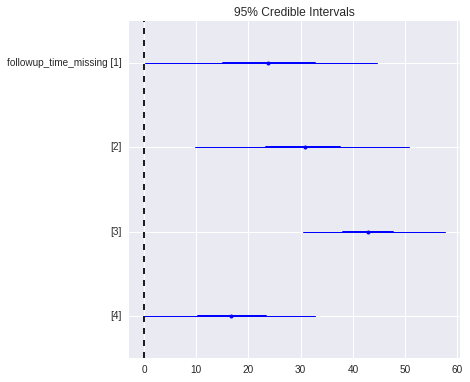

In [75]:
pm.forestplot(trace_uae[n_burn:], vars=['followup_time_missing'])

Baseline estimates for each outcome, on the log scale.

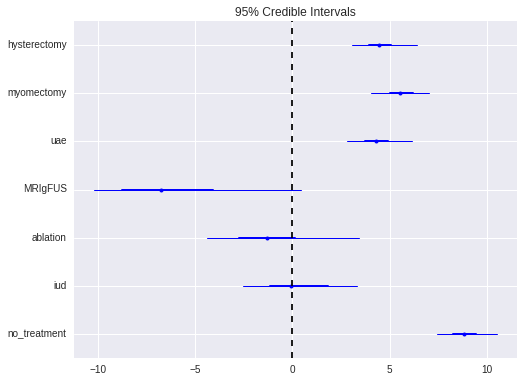

In [76]:
pm.forestplot(trace_uae[n_burn:], vars=['μ'], ylabels=plot_labels)

Follow-up time effect size estimates. Positive values indicate higher probability of event with increased follow-up time.

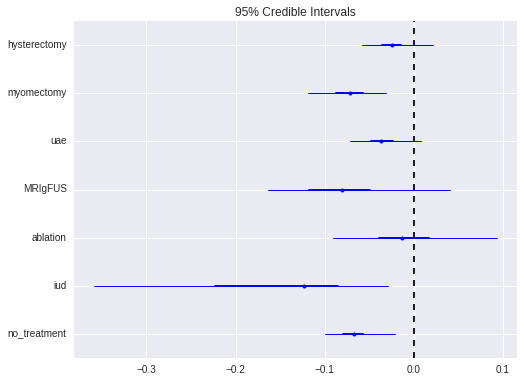

In [77]:
pm.forestplot(trace_uae[n_burn:], vars=['β_fup'], ylabels=plot_labels)

Age effect size estimates. Positive values suggest higher probability of event with each year above age 40.

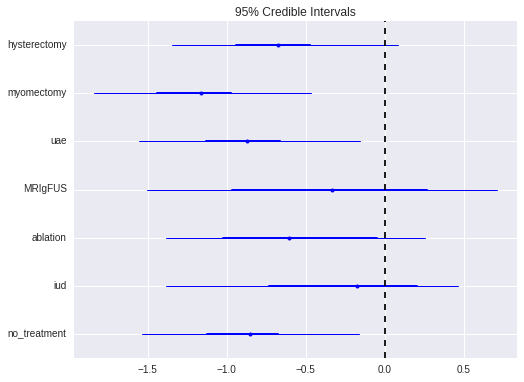

In [78]:
pm.forestplot(trace_uae[n_burn:], vars=['β_age'], ylabels=plot_labels)

Estimated probabilities of follow-up interventions for 6-month followup and age 40.

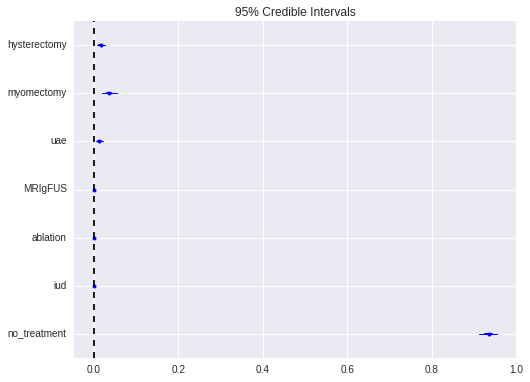

In [79]:
pm.forestplot(trace_uae[n_burn:], vars=['p_6'], ylabels=plot_labels)

Estimates corresponding to the above (in the same order as plotted)

In [80]:
pm.summary(trace_uae[n_burn:], vars=['p_6'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.016            0.005            0.000            [0.007, 0.027]
  0.036            0.009            0.001            [0.020, 0.054]
  0.013            0.004            0.000            [0.006, 0.021]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.001]
  0.000            0.001            0.000            [0.000, 0.002]
  0.934            0.011            0.001            [0.912, 0.955]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.008          0.013          0.016          0.019          0.028
  0.020          0.030          0.035          0.041          0.054
  0.006          0.010          0.013          0.016          0.022
  0.000     

Estimated probabilities of follow-up interventions for 12-month followup and age 40.

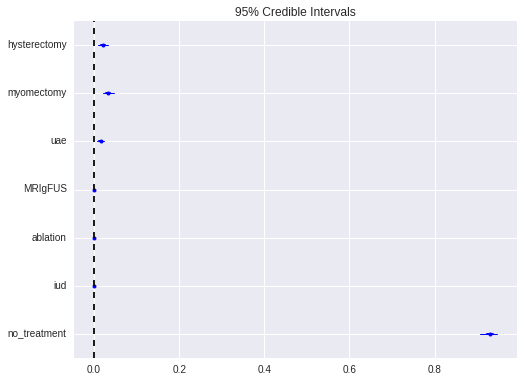

In [81]:
pm.forestplot(trace_uae[n_burn:], vars=['p_12'], ylabels=plot_labels)

In [82]:
pm.summary(trace_uae[n_burn:], vars=['p_12'])


p_12:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.021            0.006            0.000            [0.010, 0.034]
  0.034            0.007            0.000            [0.021, 0.047]
  0.016            0.004            0.000            [0.008, 0.025]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.001]
  0.000            0.000            0.000            [0.000, 0.001]
  0.929            0.010            0.001            [0.907, 0.947]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.010          0.017          0.020          0.025          0.035
  0.021          0.029          0.033          0.038          0.047
  0.008          0.013          0.016          0.019          0.025
  0.000    

Estimated probabilities of follow-up interventions for 6-month followup and age 50.

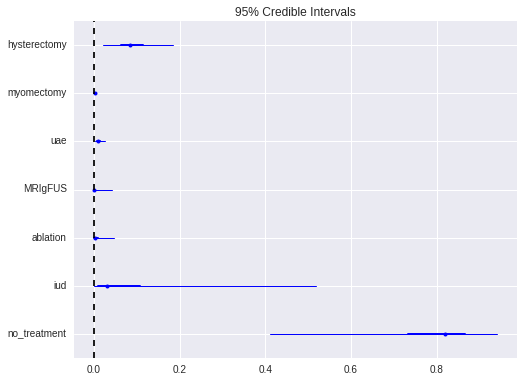

In [83]:
pm.forestplot(trace_uae[n_burn:], vars=['p_6_50'], ylabels=plot_labels)

In [84]:
pm.summary(trace_uae[n_burn:], vars=['p_6_50'])


p_6_50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.094            0.045            0.003            [0.021, 0.184]
  0.001            0.001            0.000            [0.000, 0.003]
  0.011            0.008            0.001            [0.001, 0.025]
  0.009            0.031            0.002            [0.000, 0.043]
  0.011            0.024            0.002            [0.000, 0.048]
  0.103            0.162            0.015            [0.000, 0.519]
  0.771            0.148            0.013            [0.410, 0.942]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.031          0.063          0.085          0.115          0.205
  0.000          0.001          0.001          0.002          0.004
  0.003          0.006          0.010          0.014          0.030
  0.000  

### Myomectomy model

In [59]:
myomectomy_model = specify_model(pm.Model(), 'myomectomy')

Applied interval-transform to σ and added transformed σ_interval to model.


In [60]:
with myomectomy_model:
    
    trace_myomectomy = pm.sample(n_iterations, step=pm.Metropolis(), random_seed=20140925)

 [-----------------100%-----------------] 20000 of 20000 complete in 45.6 sec

Baseline estimates on log scale

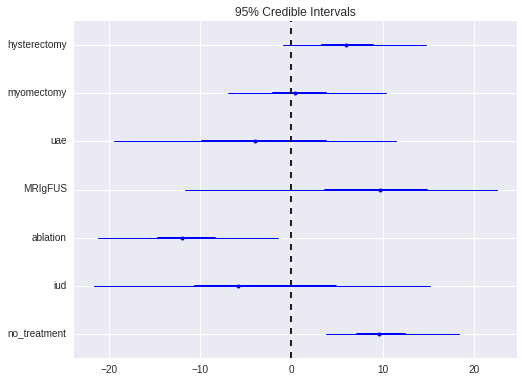

In [85]:
pm.forestplot(trace_myomectomy[n_burn:], vars=['μ'], ylabels=plot_labels)

Predicted probabilities for 6 months after followup, 40 years of age.

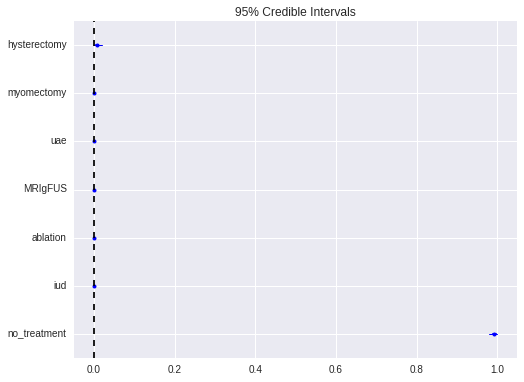

In [86]:
pm.forestplot(trace_myomectomy[n_burn:], vars=['p_6'], ylabels=plot_labels)

Predicted probabilities for all 3 scenarios.

In [87]:
pm.summary(trace_uae[n_burn:], vars=['p_6', 'p_12', 'p_6_50'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.016            0.005            0.000            [0.007, 0.027]
  0.036            0.009            0.001            [0.020, 0.054]
  0.013            0.004            0.000            [0.006, 0.021]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.001]
  0.000            0.001            0.000            [0.000, 0.002]
  0.934            0.011            0.001            [0.912, 0.955]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.008          0.013          0.016          0.019          0.028
  0.020          0.030          0.035          0.041          0.054
  0.006          0.010          0.013          0.016          0.022
  0.000     

### Medical management model

In [117]:
med_manage_model = specify_model(pm.Model(), 'med_manage', False)

Applied log-transform to nu and added transformed nu_log to model.
Applied interval-transform to σ and added transformed σ_interval to model.


In [118]:
with med_manage_model:
        
    trace_med_manage = pm.sample(n_iterations, step=pm.Metropolis(), random_seed=20140925)

 [-----------------100%-----------------] 20000 of 20000 complete in 329.0 sec

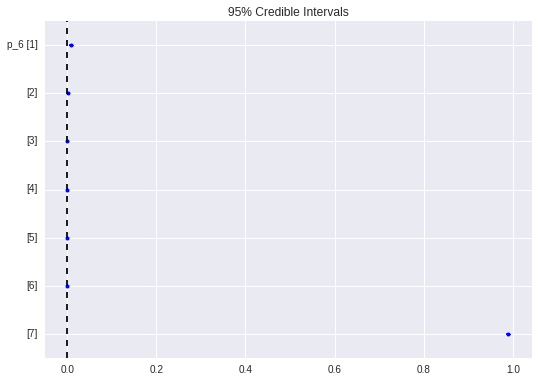

In [119]:
pm.forestplot(trace_med_manage[n_burn:], vars=['p_6'])

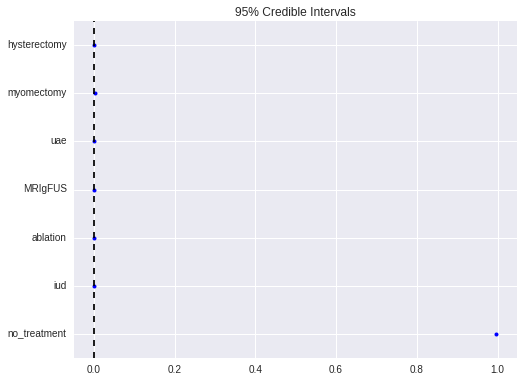

In [123]:
pm.forestplot(trace_med_manage[n_burn:], vars=['p_12'], ylabels=plot_labels)

In [120]:
pm.summary(trace_med_manage[n_burn:], vars=['p_6', 'p_12', 'p_6_50'])


p_6:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.009            0.002            0.000            [0.005, 0.013]
  0.003            0.001            0.000            [0.001, 0.005]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.989            0.002            0.000            [0.984, 0.993]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.005          0.007          0.008          0.010          0.013
  0.001          0.002          0.003          0.003          0.005
  0.000          0.000          0.000          0.000          0.000
  0.000     

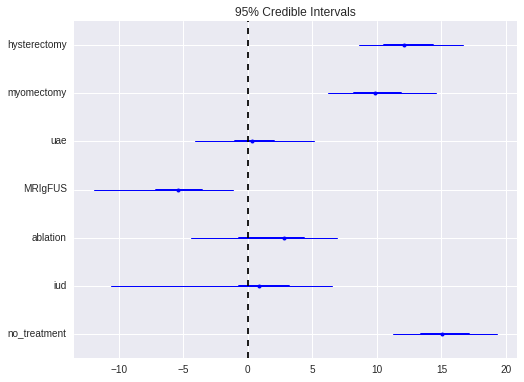

In [121]:
pm.forestplot(trace_med_manage[n_burn:], vars=['μ'], ylabels=plot_labels)

## Sandbox

This section is just for debugging. Not part of the results.

In [111]:
def get_data(intervention):
    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)]
    
    interventions = intervention_data.intervention
    
    followup_masked = masked_values(intervention_data.followup_interval.values, np.nan)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
           'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values
    
    if np.isnan(outcomes).any():
        print('Missing values in outcomes for', intervention)

    followup_n = intervention_data.followup_n.values

    # Center age at 40
    age_masked = masked_values(intervention_data['BL Mean'].values - 40, np.nan)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)    
    intervention_data = dataset[(dataset.intervention_cat==intervention)
                            & ~dataset[outcome_cats].isnull().sum(axis=1).astype(bool)]
    
    followup_masked = masked_values(intervention_data.followup_interval.values, 17.33)
    followup_min, followup_max = intervention_data[['fup_min', 'fup_max']].values.T

    outcomes = intervention_data[[ 'hysterectomy', 'myomectomy', 'uae',
           'MRIgFUS', 'ablation', 'iud', 'no_treatment']].values

    followup_n = intervention_data.followup_n.values

    age_masked = masked_values(intervention_data['BL Mean'].values, 41.33)
    
    studies = intervention_data.study_id.unique()
    study_index = np.array([np.argwhere(studies==i).squeeze() for i in intervention_data.study_id])

    study_id = intervention_data.study_id.values
    
    n_studies = len(set(study_id))

    n_outcomes = 7
    arms = len(outcomes)
    
    return locals()

In [112]:
myo = get_data('myomectomy')

In [113]:
myo['interventions']

12     myomectomy, loop ligation with vasopressin
13                    myomectomy with vasopressin
14                    myomectomy, minilaparotomic
15                       myomectomy, laparoscopic
20                    myomectomy, minilaparotomic
21                       myomectomy, laparoscopic
30                       myomectomy, laparoscopic
31                          myomectomy, abdominal
137                                    Myomectomy
138                                    Myomectomy
139                                    Myomectomy
142                                    Myomectomy
143                                    Myomectomy
Name: intervention, dtype: object

In [114]:
med_manage = get_data('med_manage')

In [116]:
med_manage['interventions']

32                                    Ulipristal (CDB10)
33                                    Ulipristal (CDB10)
34                                     Ulipristal (CD20)
35                                     Ulipristal (CD20)
38     leuprolide acetate depot (11.25 mg q 3 months)...
40                                       Asoprisnil 5 mg
41                                      Asoprisnil 10 mg
42                                      Asoprisnil 25 mg
46                                 Raloxifene, 180mg/day
48                leuprolide plus raloxifene 60 mg daily
49                               leuprolide plus placebo
50                                raloxifene 60 mg daily
51                               raloxifene 180 mg daily
53                                raloxifene 60 mg daily
55                                 tamoxifen 20 mg daily
57           leuprolide plus (tibolone 2.5 mg daily) (A)
58                                              Tibolone
60                             